In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from skimage import color

#### Functions

The ff. function converts images to grayscale

In [2]:
coef = [0.299, 0.587, 0.114] # R, G, B coefficients for conversion to grayscale, respectively

def rgb_to_gray(folder, l, P1):
    
    # 1
    if l == 'bg':
        file = f'{folder}/background.png'
    else:
        file = f'{folder}/l={l}, P1={P1}.png' # get filename
    
    img = plt.imread(f'{file}') # import the image as an array of RGB values per pixel
    
    # 2.
    # copy the values to a new array (I am not allowed to operate directly on the imported image)
    mod = img.copy().astype('float64')
    for i, c in enumerate(coef):
        mod[:,:,i] *= c # multiply the ith color value by its corresponding coefficient
                        # (e.g. 0 (red - first of the three) : 0.299 (multiplication factor))
    gray = np.sum(mod, axis=2) # sum the RGB values per pixel
    
    return gray

The ff. function stores the image arrays into one array.

In [3]:
def store_imgs(folder, l_min, l_max, l_inc, p1_min, p1_max=1):
    bg_gray = rgb_to_gray(folder, l='bg', P1='') # get the background image
    l_arr = np.round(np.arange(l_min, l_max+l_inc, l_inc), 2)
    if p1_min == p1_max:
        p1_arr = [p1_min]
    else:
        p1_arr = np.round(np.linspace(start=p1_min, stop=p1_max, num=11), 2)
    
    imgs = [] # list of image arrays

    # process and store the image arrays
    for l in l_arr:
        for p1 in p1_arr:
            gray = rgb_to_gray(folder, l=l, P1=p1) - bg_gray
            imgs.append(gray)

    imgs = np.array(imgs).reshape(len(l_arr), len(p1_arr), 2016, 2016)
    return imgs

The ff. function can be called directly after setting a figure and axes to display the images.

The ff. function gets the (position of) the intensity centroid from an image

In [4]:
def get_centroid(img):
    ny, nx = img.shape # an image has 2016 x 2016 pixels
    
    # make coordinate labels
    nX = np.linspace(start=1, stop=2016, num=2016, dtype=int);
    nY = nX # the image is a square matrix
    X, Y = np.meshgrid(nX, nY)
    
    # the center is the midpoint in x and in y: (max + min)/2
    x0 = (nx+1)/2; y0 = (ny+1)/2  # (x0, y0) = (1008.5, 1008.5)

    # each pixel's x and y distance from the center
    dX = X - x0; dY = Y - y0
    
    # get the centroid
    ## sum of product of intensities and distances from center
    xm_sum = np.sum(img*dX); ym_sum = np.sum(img*dY)
    
    ## sum of intensities (pixel values) of image
    Isum = np.sum(img)
    
    ## centroid coordinates
    xc = xm_sum/Isum; yc = ym_sum/Isum # as Cartesian
    return np.sqrt(xc**2 + yc**2) # as radial coordinate

come up with a common function for animation. That is, learn how to write animation function that takes multiple arguments.

03-07-2024 - as of now, I need to define a new animation function for each set of images, because I only know how to write animation function that takes only one argument.

[low prio] additional cleaning for displaying images. (see previous versions of this notebook)

### integer $l$

In [12]:
# the array of images for LG intensity profiles
int_imgs = store_imgs(folder='LG beams', l_min=1, l_max=5, l_inc=1, p1_min=0, p1_max=1)
int_imgs.shape

(5, 11, 2016, 2016)

for fixing - labels should be $l \in [1, 5]$ not $l \in [0, 4]$

In [13]:
# plot_grid_imgs(int_imgs) # shape (5, 11)

#### sum of all pixel values

refer to: Baluyot & Hermosa, "Intensity profiles and propagation of optical
beams with bored **helical** phase"

In [15]:
def get_sum_pixels(img):
    sums = np.sum(img, axis=(2,3)) # this should be a 2-dimensional array: rows corresponding to l, columns corresponding to p1
    return sums

In [16]:
LG_i_sums = get_sum_pixels(int_imgs)

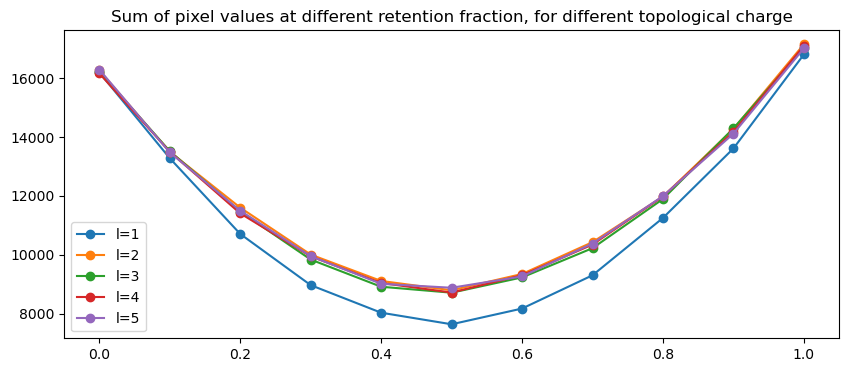

In [17]:
p1_arr = np.round(np.linspace(start=0, stop=1, num=11), 2)

fig, ax = plt.subplots()
for l in range(5):
    ax.plot(p1_arr, LG_i_sums[l], label=f'l={l+1}', marker='o')

ax.legend()
ax.set_title('Sum of pixel values at different retention fraction, for different topological charge')
fig.set_size_inches(10, 4)

mod for presentation (optional):
- normalization to a higher maximum: increase the intensity of the beams without changing the relative intensities betw. pics
- but use raw images for data analysis!

#### cylindrical lens
12/02/2024
Alperin, et al. 2016

In [18]:
cyl_int_imgs = store_imgs(folder='cyl lens', l_min=0, l_max=5, l_inc=1, p1_min=0.0)

In [19]:
# plot_grid_imgs(cyl_int_imgs)

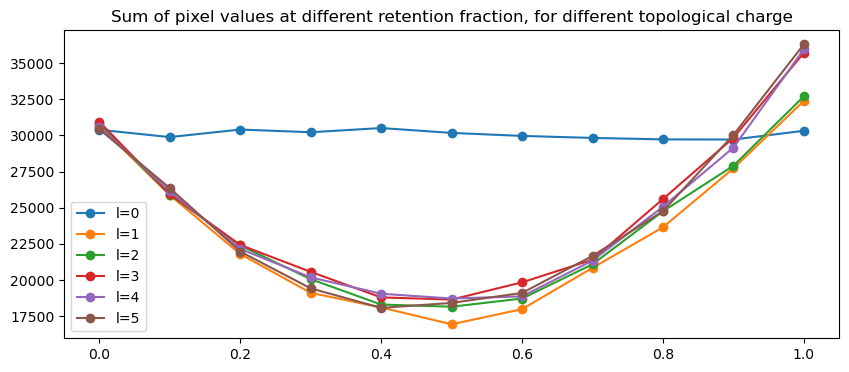

In [20]:
cyl_int_sums = get_sum_pixels(cyl_int_imgs)
np1 = cyl_int_sums.shape[1]
p1_arr = np.linspace(start=0, stop=1, num=np1)

fig, ax = plt.subplots()
for l in range(6):
    ax.plot(p1_arr, cyl_int_sums[l], label=f'l={l}', marker='o')

ax.legend()
ax.set_title('Sum of pixel values at different retention fraction, for different topological charge')
fig.set_size_inches(10, 4)

for now, only the complete phase (P1=1.0) is animated

In [26]:
def show_im_cyl_int(n):
    img = cyl_int_imgs[n, -1, :, :]
    ax.clear()
    ax.imshow(img, cmap='hot', animated=True)
    ax.set_title(f'l = {n}')

In [28]:
%matplotlib tk
fig, ax = plt.subplots()

animate = anim.FuncAnimation(fig, show_im_cyl_int, frames=cyl_int_imgs.shape[0],
                             interval=100, repeat_delay=1000)
plt.show()
# animate.save(filename='rotating_fringes.gif', writer='pillow')

# fig.clf()

### fractional $l$

#### cylindrical lens
increments of 0.2, $l \in [3, 5]$ (ignore the labels at the extreme left - they're wrong)\
03-07-2024 So far, operating on __complete__ phase, to verify if taking the centroid is a suitable method to measure OAM (method in Alperin's paper)

In [5]:
cyl_frac_imgs = store_imgs(folder='03-08-2024 cyl lens frac l', l_min=0, l_max=5.0, l_inc=0.1, p1_min=1.0)

cyl_frac_imgs.shape

(51, 1, 2016, 2016)

In [33]:
# plot_grid_imgs(cyl_frac_imgs)

Animate only the complete phase

In [8]:
def show_im_cyl_frac(n):
    img = cyl_frac_imgs[n, -1, :, :]
    ax.clear()
    ax.imshow(img, cmap='hot', animated=True)
    ax.set_title(f'l = {np.round(n*0.1, 2)}')

In [12]:
%matplotlib tk
fig, ax = plt.subplots()

animate = anim.FuncAnimation(fig, show_im_cyl_frac, frames=cyl_frac_imgs.shape[0],
                             interval=100, repeat_delay=800)
plt.show()
animate.save(filename='frac l.gif', writer='pillow')

# fig.clf()

#### raw fractional $l$ beams
Can I use the known raw beam profile corresponding to topological charges to tell the __effective__ $l$ of incomplete phase?

#### centroid
For images of beams passed through cylindrical lens
centroid ~ center of mass (where mass : intensity)

In [6]:
cyl_frac_centroids = [get_centroid(cyl_frac_imgs[i, 0, :, :]) for i in range(0, cyl_frac_imgs.shape[0])]

l = np.linspace(start=0, stop=5.0, num=51)

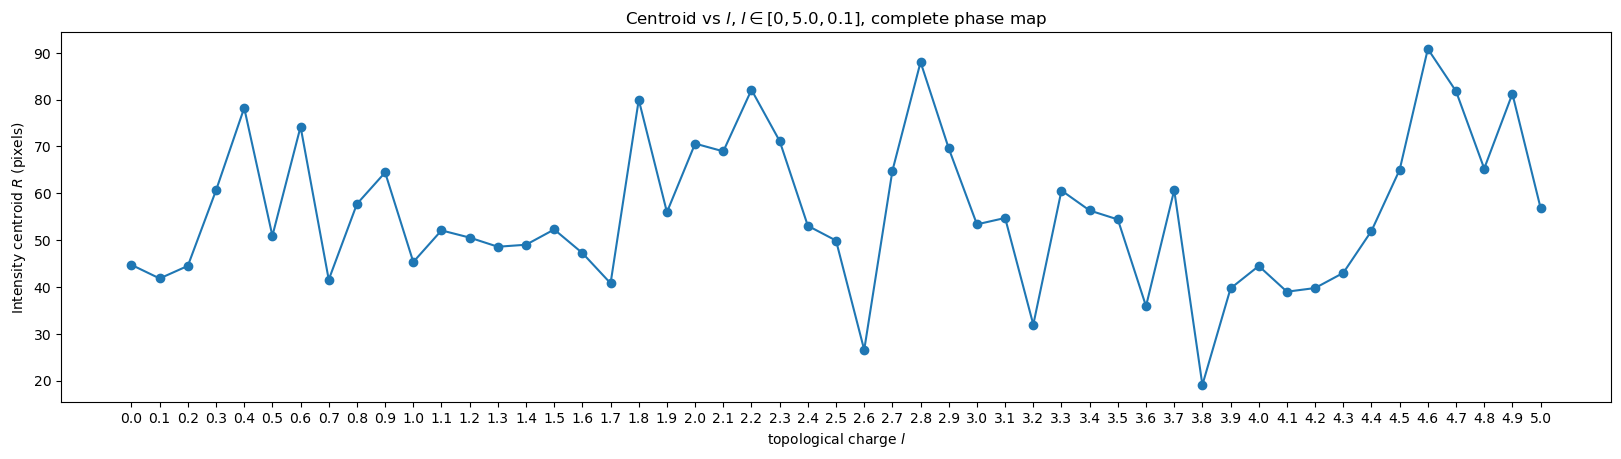

In [9]:
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(l, cyl_frac_centroids, marker='o')
ax.set(xlabel=r'topological charge $l$', ylabel='Intensity centroid $R$ (pixels)',
      title='Centroid vs $l$, $l \in [0, 5.0, 0.1]$, complete phase map',
      xticks=l)
fig.set_size_inches(20, 4.8)

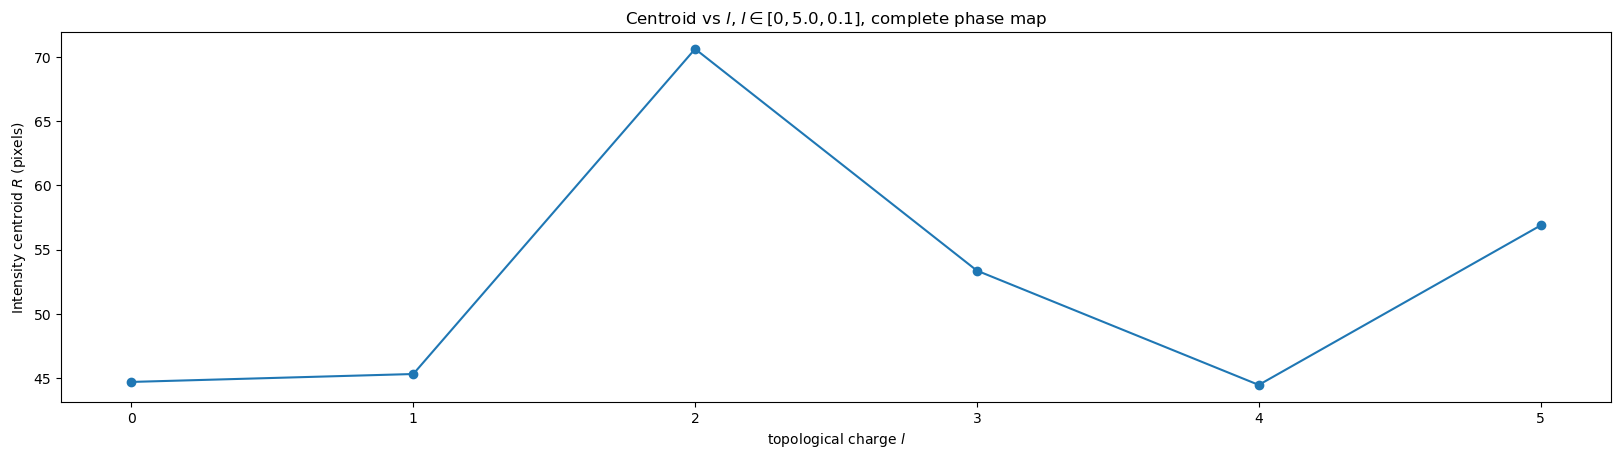

In [10]:
%matplotlib inline
# show the integer l only

fig, ax = plt.subplots()
ax.plot(l[::10], cyl_frac_centroids[::10], marker='o')
ax.set(xlabel=r'topological charge $l$', ylabel='Intensity centroid $R$ (pixels)',
      title='Centroid vs $l$, $l \in [0, 5.0, 0.1]$, complete phase map',
      xticks=l[::10])
fig.set_size_inches(20, 4.8)

Now plot the centroid __w.r.t. centroid at $l=0$__

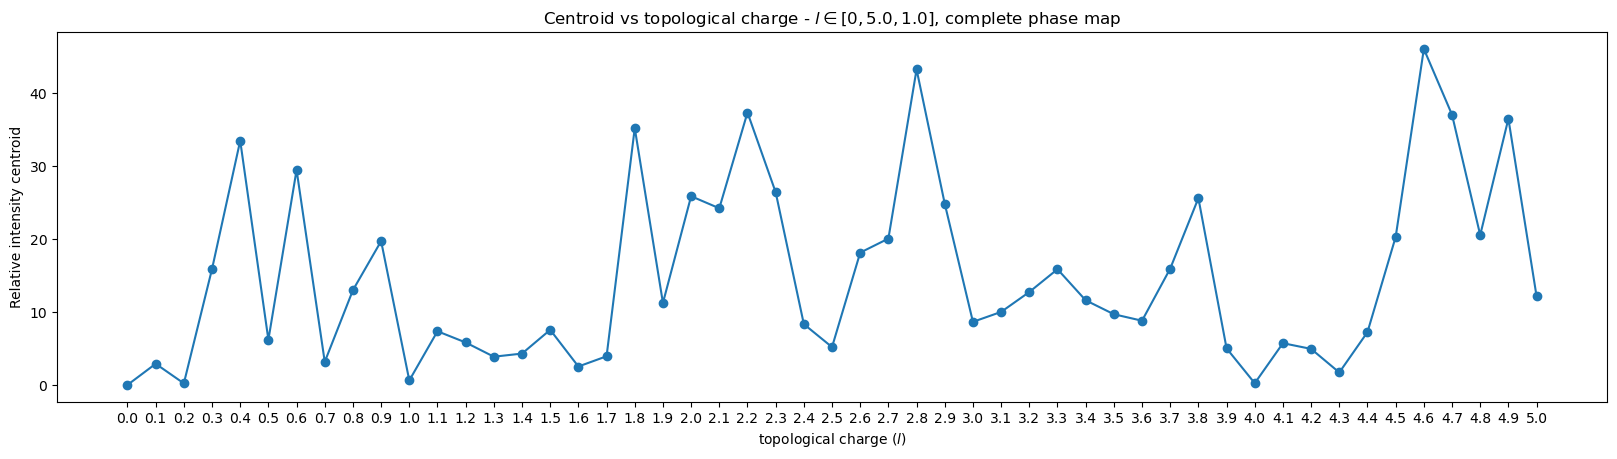

In [11]:
rel_centroids = np.abs(cyl_frac_centroids - cyl_frac_centroids[0])

fig, ax = plt.subplots()
ax.plot(l, rel_centroids, marker='o')
ax.set(xlabel=r'topological charge ($l$)', ylabel='Relative intensity centroid',
      title='Centroid vs topological charge - $l \in [0, 5.0, 1.0]$, complete phase map',
      xticks=l)
fig.set_size_inches(20, 4.8)

So far, the intensity centroid does not exhibit any clear relationship with topological charge. Failed to replicate the graphs of Alperin (2016)

attempt 2: "correct" each set of 10 (ex. 0.1 to 1.0)

### to do - analysis
- Should I curvefit?
- test your functions, draw them out if you have to.
- from literature, come up with other ways to quantify the OAM of beams (complete phase)

### Outlook

---
###### archived

#### ~Radon transform~
For an image projected on some 2D plane, the Radon transform displays the integral of intensities for line scans at some angle phi, for discrete radii (see p. 57, The Radon Transform and Some of its Applications [Dean, S.R.])

02-19-2023 still studying how to implement and interpret the Radon transform.

Other methods to characterize vortices: single mode fiber, interferometry.
I also captured images of _negative_ topological charge through a cylindrical lens (not yet included in this notebook; I don't know if I will include it because there's nothing unexpected).

What can I find using my results?
- What is the threshold of the cylindrical lens being an effective way to quantify OAM? (based off Alperin)
- Try **fractional topological charge** (the Russian paper)
- What now is the topological charge when, for some initial l, the phase is more and more incomplete?


More data processing to try:
- Radon transform. What pattern will arise? With respect to what? is it more useful?
- get the centroid
- ~mode projection??~